<a href="https://colab.research.google.com/github/msaroufim/mlsys-experiments/blob/main/Torch_IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

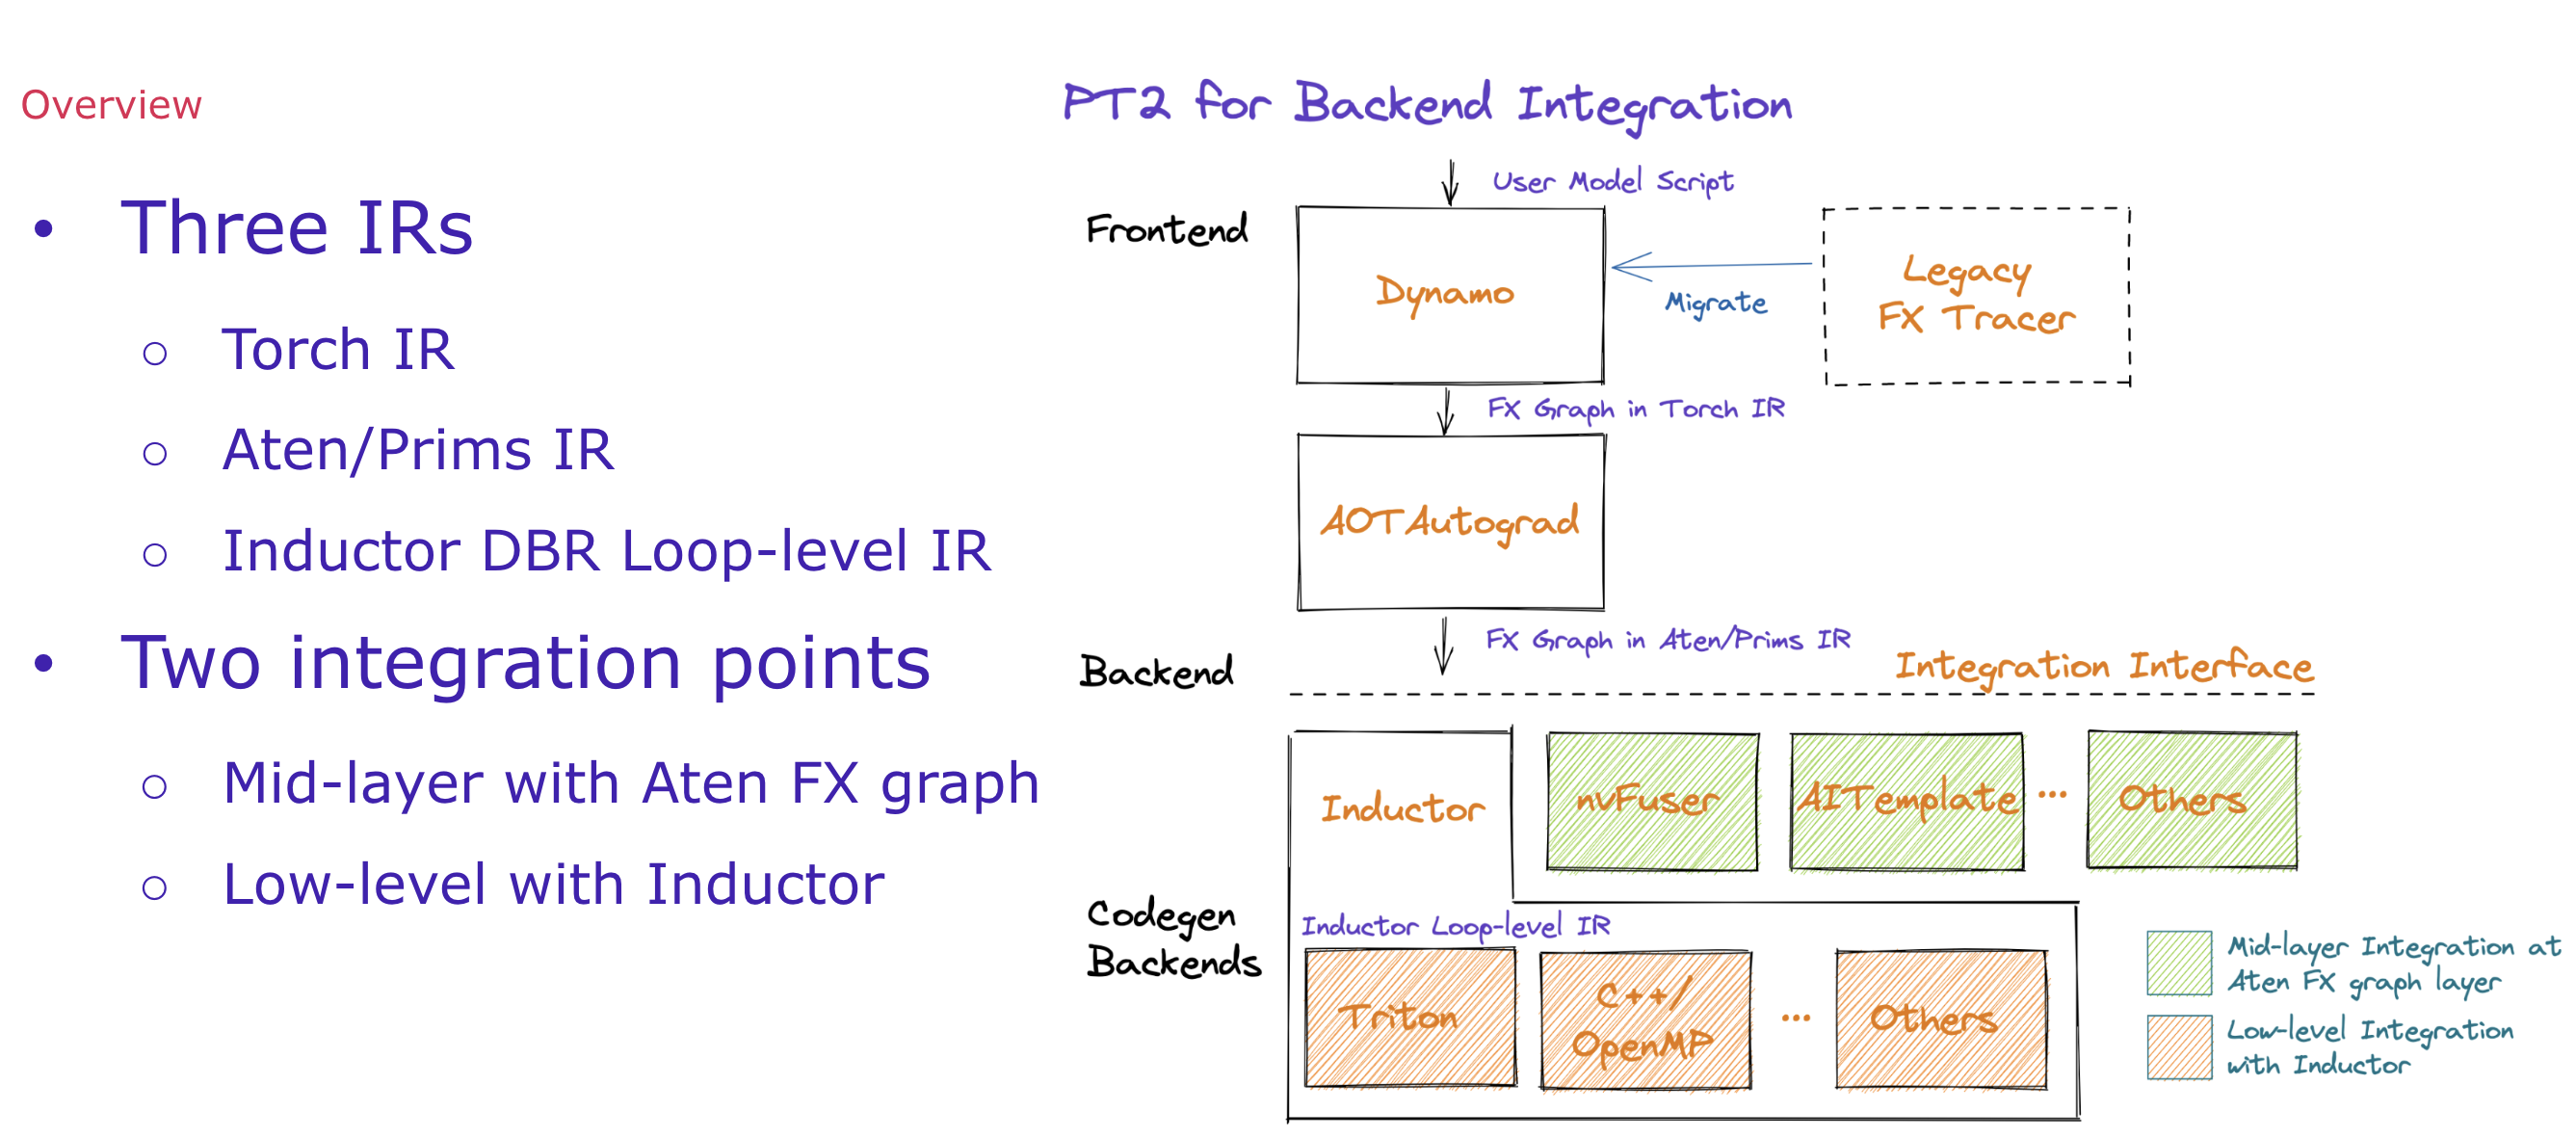

References - mostly influenced by Sherlock's doc
* https://colab.research.google.com/drive/1Zh-Uo3TcTH8yYJF-LLo5rjlHVMtqvMdf
* https://pytorch.org/docs/stable/jit.html
* https://github.com/pytorch/pytorch/blob/main/docs/source/compile/transformations.rst
* https://pytorch.org/docs/master/ir.html
* https://github.com/pytorch/pytorch/tree/main/torch/_dynamo/backends
* https://github.com/pytorch/pytorch/blob/main/torch/_dynamo/backends/common.py
* https://github.com/pytorch/pytorch/blob/main/torch/_dynamo/backends/inductor.py
* https://pytorch.org/docs/stable/fx.html#torch.fx.Interpreter

In [ ]:
import torch
assert torch.__version__ >= '2.0.*'

**A linear layer with gelu activation**

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(32, 64).cpu()

  def forward(self, x):
    x = self.fc1(x)
    x = torch.nn.functional.gelu(x)
    return x

model = MLP()

batch_size = 8
input = torch.randn(batch_size, 32)

**Invoke torch.compile, which produces a fx graph in Torch IR**

In [ ]:
import torch._dynamo
from torch._functorch.aot_autograd import aot_module_simplified

def toy_backend(gm, sample_inputs):
    print("Dynamo produced a fx Graph in Torch IR:")
    gm.print_readable()

    print("Notice that sample_inputs is a list of flattened FakeTensor:")
    print("Why not uses Real tensors?")
    print(sample_inputs)
    return gm.forward

torch._dynamo.reset()
fn = torch.compile(backend=toy_backend, dynamic=False)(model)

# triggers compilation of forward graph on the first run
out = fn(input)

Dynamo produced a fx Graph in Torch IR:
class GraphModule(torch.nn.Module):
    def forward(self, x : torch.Tensor):
        # File: <ipython-input-8-ade5b0d49fcc>:9, code: x = self.fc1(x)
        self_fc1 = self.self_fc1(x);  x = None
        
        # File: <ipython-input-8-ade5b0d49fcc>:10, code: x = torch.nn.functional.gelu(x)
        gelu = torch._C._nn.gelu(self_fc1);  self_fc1 = None
        return (gelu,)
        
Notice that sample_inputs is a list of flattened FakeTensor:
Why not uses Real tensors?
[FakeTensor(FakeTensor(..., device='meta', size=(8, 32)), cpu)]


In [ ]:
import torch._dynamo
from torch._functorch.aot_autograd import aot_module_simplified

def toy_backend(gm, sample_inputs):
    print("Dynamo produced a fx Graph in Torch IR:")
    gm.print_readable()

    print("Notice how size = (s, 32)")
    print(sample_inputs)
    return gm.forward

torch._dynamo.reset()
fn = torch.compile(backend=toy_backend, dynamic=True)(model)

# triggers compilation of forward graph on the first run
out = fn(input)

Dynamo produced a fx Graph in Torch IR:
class GraphModule(torch.nn.Module):
    def forward(self, x : torch.Tensor):
        # File: <ipython-input-8-ade5b0d49fcc>:9, code: x = self.fc1(x)
        self_fc1 = self.self_fc1(x);  x = None
        
        # File: <ipython-input-8-ade5b0d49fcc>:10, code: x = torch.nn.functional.gelu(x)
        gelu = torch._C._nn.gelu(self_fc1);  self_fc1 = None
        return (gelu,)
        
Notice how size = (s, 32)
[FakeTensor(FakeTensor(..., device='meta', size=(s0, 32)), cpu)]


**Invoke AOTAutograd, produces forward + backward FX graph in Aten IR**
- Captures forward + backwards
- Lowering from Torch IR to Aten/Prims IR
- Cleansed graph via functionalization
- Populated graph with metadata: symbolic shape, dtype…

In [ ]:
import torch._dynamo
from torch._functorch.aot_autograd import aot_module_simplified

def toy_backend(gm, sample_inputs): 
    def my_compiler(gm, sample_inputs):
        # <implement your compiler here>
        print("AOTAutograd produced a fx Graph in Aten IR:")
        gm.print_readable()
        return gm.forward

    # Invoke AOTAutograd
    return aot_module_simplified(
        gm,
        sample_inputs,
        fw_compiler=my_compiler
    )

torch._dynamo.reset()
fn = torch.compile(backend=toy_backend, dynamic=True)(model)

# triggers compilation of forward graph on the first run
out = fn(input)

# triggers compilation of backward graph on the first run
out.sum().backward()

AOTAutograd produced a fx Graph in Aten IR:
class GraphModule(torch.nn.Module):
    def forward(self, primals_1: f32[64, 32], primals_2: f32[64], primals_3: f32[s0, 32]):
        # File: <ipython-input-8-ade5b0d49fcc>:9, code: x = self.fc1(x)
        t: f32[32, 64] = torch.ops.aten.t.default(primals_1);  primals_1 = None
        addmm: f32[s0, 64] = torch.ops.aten.addmm.default(primals_2, primals_3, t);  primals_2 = t = None
        
        # File: <ipython-input-8-ade5b0d49fcc>:10, code: x = torch.nn.functional.gelu(x)
        gelu: f32[s0, 64] = torch.ops.aten.gelu.default(addmm)
        return [gelu, addmm, primals_3]
        
AOTAutograd produced a fx Graph in Aten IR:
class GraphModule(torch.nn.Module):
    def forward(self, addmm: f32[s0, 64], primals_3: f32[s0, 32], tangents_1: f32[s0, 64]):
        # File: <ipython-input-8-ade5b0d49fcc>:10, code: x = torch.nn.functional.gelu(x)
        gelu_backward: f32[s0, 64] = torch.ops.aten.gelu_backward.default(tangents_1, addmm);  tange

/usr/local/lib/python3.10/dist-packages/torch/_functorch/aot_autograd.py:1251: UserWarning: Your compiler for AOTAutograd is returning a a function that doesn't take boxed arguments. Please wrap it with functorch.compile.make_boxed_func or handle the boxed arguments yourself. See https://github.com/pytorch/pytorch/pull/83137#issuecomment-1211320670 for rationale.
  warnings.warn(


In [ ]:
# You can call torch.ops directly on torch tensors
a = torch.randn(10,1)
print(a.shape)
b = torch.ops.aten.t.default(a)
print(b.shape)

torch.Size([10, 1])
torch.Size([1, 10])


In [ ]:
# What are these ops
dir(torch.ops)

['__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dir',
 'aten',
 'loaded_libraries',
 'mkl',
 'mkldnn',
 'nvprims',
 'prim',
 'prims',
 'profiler',
 'pyops',
 'quantized']

In [ ]:
dir(torch.ops.aten)

['__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_adaptive_avg_pool2d',
 '_adaptive_avg_pool2d_backward',
 '_adaptive_avg_pool3d',
 '_cdist_forward',
 '_cudnn_rnn',
 '_dir',
 '_embedding_bag',
 '_embedding_bag_forward_only',
 '_euclidean_dist',
 '_fft_c2c',
 '_fft_c2r',
 '_fft_r2c',
 '_fused_dropout',
 '_fused_moving_avg_obs_fq_helper',
 '_linalg_det',
 '_linalg_svd',
 '_list_to_tensor',
 '_local_scalar_dense',
 '_log_softmax',
 '_log_softmax_backward_data',
 '_native_batch_norm_legit',
 '_native_batch_norm_legit_functional',
 '_nested_tensor_from_tensor_list',
 '_pin_memory',
 '_prelu_kernel',
 '_prelu_kernel_backward',
 '_reshape_alias',
 '_resize_output',
 '_resize_output_',
 '_scaled_dot_product_efficient_attention',
 '_scaled_dot_product_efficient_attention_backward',
 '_scaled_dot_product_flash_attention',
 '_scaled_dot_product_flash_attention_backward',
 '_softmax',
 '_softmax_backward_data',
 '_sparse_coo_tensor_with_dims_and_tensors',
 '_standard_gamma',


In [ ]:
print(len(dir(torch.ops.aten)))
print(len(dir(torch.ops.prims)))

601
128


In [ ]:
# Let's talk decomps
torch.ops.aten.hardswish

# torch.ops.prims.hardswish
# Does this reaally need to be its own op?

# Let's take a look at an example https://github.com/pytorch/pytorch/blob/main/torch/_decomp/decompositions.py#L189


AttributeError: ignored

In [ ]:
from torch._decomp import core_aten_decompositions

# Backends can further finetune the decompositions if needed
# Available decompositions can be found in
# torch/_decomp/decompositions.py and torch/_refs/__init__.py


decompositions = core_aten_decompositions()
decompositions.update(
    torch._decomp.get_decompositions([
        torch.ops.aten.addmm,
    ])
)

def toy_backend(gm, sample_inputs):
    def my_compiler(gm, sample_inputs):
        # <implement your compiler here>
        print("Decomposed fx Graph in Aten IR:")
        gm.print_readable()
        return gm

    # Invoke AOTAutograd
    return aot_module_simplified(
        gm,
        sample_inputs,
        decompositions=decompositions,
        fw_compiler=my_compiler
    )

torch._dynamo.reset()
fn = torch.compile(backend=toy_backend, dynamic=True)(model)
out = fn(input)

Decomposed fx Graph in Aten IR:
class GraphModule(torch.nn.Module):
    def forward(self, primals_1: f32[64, 32], primals_2: f32[64], primals_3: f32[s0, 32]):
        # File: <ipython-input-8-ade5b0d49fcc>:9, code: x = self.fc1(x)
        permute: f32[32, 64] = torch.ops.aten.permute.default(primals_1, [1, 0]);  primals_1 = None
        mm: f32[s0, 64] = torch.ops.aten.mm.default(primals_3, permute);  permute = None
        mul: f32[s0, 64] = torch.ops.aten.mul.Tensor(mm, 1);  mm = None
        mul_1: f32[64] = torch.ops.aten.mul.Tensor(primals_2, 1);  primals_2 = None
        add: f32[s0, 64] = torch.ops.aten.add.Tensor(mul, mul_1);  mul = mul_1 = None
        
        # File: <ipython-input-8-ade5b0d49fcc>:10, code: x = torch.nn.functional.gelu(x)
        mul_2: f32[s0, 64] = torch.ops.aten.mul.Tensor(add, 0.5)
        mul_3: f32[s0, 64] = torch.ops.aten.mul.Tensor(add, 0.7071067811865476)
        erf: f32[s0, 64] = torch.ops.aten.erf.default(mul_3);  mul_3 = None
        add_1: f32[

/usr/local/lib/python3.10/dist-packages/torch/_functorch/aot_autograd.py:1251: UserWarning: Your compiler for AOTAutograd is returning a a function that doesn't take boxed arguments. Please wrap it with functorch.compile.make_boxed_func or handle the boxed arguments yourself. See https://github.com/pytorch/pytorch/pull/83137#issuecomment-1211320670 for rationale.
  warnings.warn(


**Core Aten IR** (https://pytorch.org/docs/master/ir.html#core-aten-ir)
- A strict subset of aten operators (< 250) after decompositions
- Purely functional (no inputs mutations）
- Guaranteed metadata information, e.g. dtype and shape propagation
- Effectively the output IR of PT2’s export path 
- For backends that wants an eager-like opset


**Prims IR** (https://pytorch.org/docs/master/ir.html#prims-ir)
- Explicit type promotion and broadcasting
    - prims.convert_element_type
    - prims.broadcast_in_dim
- For backends with powerful compiler that can reclaim the performance by fusion, e.g. nvFuser


In [ ]:
[op for op in dir(torch.ops.aten) if "add" in op]

['add',
 'add_',
 'addbmm',
 'addbmm_',
 'addcdiv',
 'addcdiv_',
 'addcmul',
 'addcmul_',
 'addmm',
 'addmm_',
 'addmv',
 'addmv_',
 'addr',
 'baddbmm',
 'baddbmm_',
 'index_add',
 'index_add_',
 'logaddexp',
 'logaddexp2',
 'scatter_add',
 'scatter_add_']

In [ ]:
prims_decomp = torch._decomp.get_decompositions([
    torch.ops.aten.add,
    # torch.ops.aten.expand.default,
])

print("The decomps are")
print(prims_decomp)

def fn(a, b):
    return a + b

def toy_backend(gm, sample_inputs):
    def my_compiler(gm, sample_inputs):
        # <implement your compiler here>
        print("Further decomposed fx Graph in Prims IR:")
        gm.print_readable()
        return gm

    # Invoke AOTAutograd
    return aot_module_simplified(
        gm,
        sample_inputs,
        decompositions=prims_decomp,
        fw_compiler=my_compiler
    )

torch._dynamo.reset()
fn = torch.compile(backend=toy_backend)(fn)
out = fn(torch.rand(3, dtype=torch.float), torch.rand(3, 3, dtype=torch.half))

The decomps are
{<OpOverload(op='aten.add', overload='Tensor')>: <function add at 0x7fbb39c38a60>, <OpOverload(op='aten.add', overload='Scalar')>: <function add at 0x7fbb39c38a60>, <OpOverload(op='aten.add', overload='out')>: <function add at 0x7fbb39c38a60>, <OpOverload(op='aten.add', overload='Scalar_out')>: <function add at 0x7fbb39c38a60>}
Further decomposed fx Graph in Prims IR:
class <lambda>(torch.nn.Module):
    def forward(self, arg0_1: f32[3], arg1_1: f16[3, 3]):
        # File: <ipython-input-34-109ee3bc1e26>:10, code: return a + b
        _to_copy: f32[3, 3] = torch.ops.aten._to_copy.default(arg1_1, dtype = torch.float32);  arg1_1 = None
        expand: f32[3, 3] = torch.ops.aten.expand.default(arg0_1, [3, 3]);  arg0_1 = None
        add: f32[3, 3] = torch.ops.prims.add.default(expand, _to_copy);  expand = _to_copy = None
        return (add,)
        


**Partial graph compilation with a Partitioner**
- Given the supported operators, it forms the largest subgraphs supported by a backend.
- Partitioned subgraphs can be delegated to a backend
- Remaining graphs can fallback to aten kernel


In [ ]:
from torch.fx.passes.infra.partitioner import CapabilityBasedPartitioner
from torch.fx.passes.operator_support import OperatorSupport
	
class ToyOperatorSupport(OperatorSupport):
    def is_node_supported(self, submodules, node: torch.fx.Node) -> bool:
        if node.target in {
            torch.ops.aten.mul.Tensor, 
            torch.ops.aten.add.Tensor,
        }:
            return True
        return False

def partition(gm):
    supported_ops = ToyOperatorSupport()
    partitioner = CapabilityBasedPartitioner(gm, supported_ops)
    fused_graph = partitioner.partition_and_fuse()
    return fused_graph

def toy_backend(gm, sample_inputs):
    def my_compiler(gm, sample_inputs):
        gm = partition(gm)
        gm.print_readable()
        # <implement your backend here>    
        return gm

    # Invoke AOTAutograd
    return aot_module_simplified(
        gm,
        sample_inputs,
        decompositions=decompositions,
        fw_compiler=my_compiler
    )

torch._dynamo.reset()
fn = torch.compile(backend=toy_backend, dynamic=True)(model)
out = fn(input)

class GraphModule(torch.nn.Module):
    def forward(self, primals_1: f32[64, 32], primals_2: f32[64], primals_3: f32[s0, 32]):
        # File: <ipython-input-8-ade5b0d49fcc>:9, code: x = self.fc1(x)
        permute: f32[32, 64] = torch.ops.aten.permute.default(primals_1, [1, 0]);  primals_1 = None
        mm: f32[s0, 64] = torch.ops.aten.mm.default(primals_3, permute);  permute = None
        
        # No stacktrace found for following nodes
        fused_1 = self.fused_1(mm, primals_2);  mm = primals_2 = None
        
        # File: <ipython-input-8-ade5b0d49fcc>:9, code: x = self.fc1(x)
        getitem: f32[s0, 64] = fused_1[0]
        
        # File: <ipython-input-8-ade5b0d49fcc>:10, code: x = torch.nn.functional.gelu(x)
        getitem_1: f32[s0, 64] = fused_1[1];  fused_1 = None
        erf: f32[s0, 64] = torch.ops.aten.erf.default(getitem_1);  getitem_1 = None
        fused_0: f32[s0, 64] = self.fused_0(erf, getitem);  erf = None
        return [fused_0, primals_3, getitem]
 

/usr/local/lib/python3.10/dist-packages/torch/_functorch/aot_autograd.py:1251: UserWarning: Your compiler for AOTAutograd is returning a a function that doesn't take boxed arguments. Please wrap it with functorch.compile.make_boxed_func or handle the boxed arguments yourself. See https://github.com/pytorch/pytorch/pull/83137#issuecomment-1211320670 for rationale.
  warnings.warn(


**Graph rewrite with PatternMatcher**
- Finds all the matched subgraph according to the provided pattern 
- IR Agnostic: works for Torch IR, Aten IR, Prims IR
- Replace matched subgraph with another graph


In [ ]:
from torch.fx import subgraph_rewriter

def gelu_pattern(x):
    mul_2 = torch.ops.aten.mul.Tensor(x, 0.5)
    mul_3 = torch.ops.aten.mul.Tensor(x, 0.7071067811865476)
    erf = torch.ops.aten.erf.default(mul_3)
    add_1 = torch.ops.aten.add.Tensor(erf, 1)
    mul_4 = torch.ops.aten.mul.Tensor(mul_2, add_1)
    return mul_4

def gelu_tanh_replacement(x):
    return torch.ops.aten.gelu.default(x, approximate = 'tanh')

def gelu_replacement(x):
    mul_2 = torch.ops.aten.mul.Tensor(x, x)
    mul_3 = torch.ops.aten.mul.Tensor(mul_2, x)
    mul_4 = torch.ops.aten.mul.Tensor(mul_3, 0.044715)
    add_1 = torch.ops.aten.add.Tensor(x, mul_4)
    mul_5 = torch.ops.aten.mul.Tensor(x, 0.7978845608028654)
    mul_6 = torch.ops.aten.mul.Tensor(x, 0.5)
    tanh = torch.ops.aten.tanh.default(mul_5)
    add_2 = torch.ops.aten.add.Tensor(tanh, 1)
    mul_7 = torch.ops.aten.mul.Tensor(mul_6, add_2)
    return mul_7

def toy_backend(gm, sample_inputs):
    def my_compiler(gm, sample_inputs):
        print("Before")
        gm.print_readable()

        matches = subgraph_rewriter.replace_pattern(gm, gelu_pattern, gelu_replacement)    
        # matches = subgraph_rewriter.replace_pattern(gm, gelu_pattern, gelu_tanh_replacement)    

        print("After")
        gm.print_readable()
        # <implement your backend here>
        return gm

    # helper function to run AOTAutograd manually
    return aot_module_simplified(
        gm,
        sample_inputs,
        decompositions=decompositions,
        fw_compiler=my_compiler
    )

torch._dynamo.reset()
fn = torch.compile(backend=toy_backend, dynamic=True)(model)
out = fn(input)



Before
class GraphModule(torch.nn.Module):
    def forward(self, primals_1: f32[64, 32], primals_2: f32[64], primals_3: f32[s0, 32]):
        # File: <ipython-input-8-ade5b0d49fcc>:9, code: x = self.fc1(x)
        permute: f32[32, 64] = torch.ops.aten.permute.default(primals_1, [1, 0]);  primals_1 = None
        mm: f32[s0, 64] = torch.ops.aten.mm.default(primals_3, permute);  permute = None
        mul: f32[s0, 64] = torch.ops.aten.mul.Tensor(mm, 1);  mm = None
        mul_1: f32[64] = torch.ops.aten.mul.Tensor(primals_2, 1);  primals_2 = None
        add: f32[s0, 64] = torch.ops.aten.add.Tensor(mul, mul_1);  mul = mul_1 = None
        
        # File: <ipython-input-8-ade5b0d49fcc>:10, code: x = torch.nn.functional.gelu(x)
        mul_2: f32[s0, 64] = torch.ops.aten.mul.Tensor(add, 0.5)
        mul_3: f32[s0, 64] = torch.ops.aten.mul.Tensor(add, 0.7071067811865476)
        erf: f32[s0, 64] = torch.ops.aten.erf.default(mul_3);  mul_3 = None
        add_1: f32[s0, 64] = torch.ops.aten.

/usr/local/lib/python3.10/dist-packages/torch/_functorch/aot_autograd.py:1251: UserWarning: Your compiler for AOTAutograd is returning a a function that doesn't take boxed arguments. Please wrap it with functorch.compile.make_boxed_func or handle the boxed arguments yourself. See https://github.com/pytorch/pytorch/pull/83137#issuecomment-1211320670 for rationale.
  warnings.warn(


In [ ]:
torch.compile(fullgraph=True)

# If fails
# 1. Open bug report with torch.compile
#2. dynamic=True
#3. Rewrite user program to avoid graph breaks


# torch.compile(m) but don't compile the kv cache

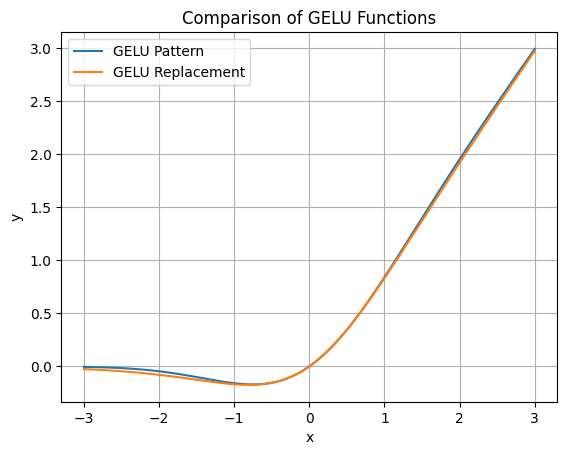

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def gelu_pattern(x):
    mul_2 = x * 0.5
    mul_3 = x * 0.7071067811865476

    # Slow involves an integration
    erf = np.vectorize(np.math.erf)(mul_3)
    add_1 = erf + 1
    mul_4 = mul_2 * add_1
    return mul_4



def gelu_replacement(x):
    mul_2 = x * x
    mul_3 = mul_2 * x
    mul_4 = mul_3 * 0.044715
    add_1 = x + mul_4
    mul_5 = x * 0.7978845608028654
    mul_6 = x * 0.5
    tanh = np.tanh(mul_5)
    add_2 = tanh + 1
    mul_7 = mul_6 * add_2
    return mul_7

x = np.linspace(-3, 3, 1000)

plt.plot(x, gelu_pattern(x), label='GELU Pattern')
plt.plot(x, gelu_replacement(x), label='GELU Replacement')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of GELU Functions')
plt.grid()
plt.show()

# Let's do the hello world of optimization passes


In [ ]:
class TransposeModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
  
  def forward(self,x):
    return x.t().t()
  
transpose_model = TransposeModel()

In [ ]:
class TransposeModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
  
  def forward(self,x):
    return x.t().t()
  
transpose_model = TransposeModel()

import torch
from torch.fx import subgraph_rewriter

def transpose_pattern(x):
  t = torch.ops.aten.t.default(x)
  t_1 = torch.ops.aten.t.default(t)
  return t_1

def transpose_replacement(x):
  return x

def toy_backend(gm, sample_inputs):
  def my_compiler(gm, sample_inputs):
      print("Before")
      gm.print_readable()

      matches = subgraph_rewriter.replace_pattern(gm, transpose_pattern, transpose_replacement)

      print("After")
      gm.print_readable()
      return gm

  return aot_module_simplified(
      gm,
      sample_inputs,
      fw_compiler=my_compiler
  )

torch._dynamo.reset()
fn = torch.compile(backend=toy_backend)(transpose_model)
out = fn(input)

Before
class <lambda>(torch.nn.Module):
    def forward(self, arg0_1: f32[8, 32]):
        # File: <ipython-input-25-f90c4c8b3643>:6, code: return x.t().t()
        t: f32[32, 8] = torch.ops.aten.t.default(arg0_1);  arg0_1 = None
        t_1: f32[8, 32] = torch.ops.aten.t.default(t);  t = None
        return (t_1,)
        
After
class <lambda>(torch.nn.Module):
    def forward(self, arg0_1: f32[8, 32]):
        return (arg0_1,)
        


# What about shape padding?
Multiplying tensors of odd sizes is generally slower then even sizes especially for large tensors

So the idea behind this is 

In [ ]:
class MatMulModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * x


model = MatMulModel()

import torch
from torch.fx import subgraph_rewriter


def matmul_pattern(x):
    x = torch.ops.aten.mul.Tensor(x, x)
    return x


def padded_matmul(x):
    z = torch.zeros_like(x)
    x = torch.ops.aten.cat([x, z], dim=0)
    x = torch.ops.aten.mul.Tensor(x, x)
    x = torch.ops.aten.narrow(x, 0, 0, x.shape[0] // 2)

    return x


def toy_backend(gm, sample_inputs):
    def my_compiler(gm, sample_inputs):
        print("Before")
        gm.print_readable()

        matches = subgraph_rewriter.replace_pattern(gm, matmul_pattern, padded_matmul)

        print("After")
        gm.print_readable()
        return gm

    return aot_module_simplified(
        gm,
        sample_inputs,
        fw_compiler=my_compiler
    )


torch._dynamo.reset()
fn = torch.compile(backend=toy_backend)(model)
inp = torch.randn(3, 3)

# Ensure tensor dimensions are odd
for shape in inp.shape:
    assert shape % 2 != 0

out = fn(inp)

print(out.shape)

Before
class <lambda>(torch.nn.Module):
    def forward(self, arg0_1: f32[3, 3]):
        # File: <ipython-input-28-37acb68f3eef>:6, code: return x * x
        mul: f32[3, 3] = torch.ops.aten.mul.Tensor(arg0_1, arg0_1);  arg0_1 = None
        return (mul,)
        
After
class <lambda>(torch.nn.Module):
    def forward(self, arg0_1: f32[3, 3]):
        # No stacktrace found for following nodes
        zeros_like = torch.zeros_like(arg0_1)
        cat = torch.ops.aten.cat([arg0_1, zeros_like], dim = 0);  arg0_1 = zeros_like = None
        mul_tensor = torch.ops.aten.mul.Tensor(cat, cat);  cat = None
        getattr_1 = mul_tensor.shape
        getitem = getattr_1[0];  getattr_1 = None
        floordiv = getitem // 2;  getitem = None
        narrow = torch.ops.aten.narrow(mul_tensor, 0, 0, floordiv);  mul_tensor = floordiv = None
        return (narrow,)
        
torch.Size([3, 3])
